**The Code in this document tries to predict the 1v1 win chances of players for an age of empires match**

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import pandas as pd
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss, brier_score_loss
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

Step 1: Create the dataframe to work with

In [16]:
df = pd.read_csv('final2.csv')
df.head()

,team_size,team_A_avg_mmr,team_B_avg_mmr,team_A_civs,team_B_civs,map_name,team_A_won,civ_A_vs_B_winrate,civ_A_vs_B_certainty,mmr_gap
0,1,2294.0,2297.0,french,house_of_lancaster,Dry Arabia,0,42.993025,0.503591,-3.0
1,1,2290.0,2165.0,mongols,chinese,Gorge,1,53.023663,0.112949,125.0
2,1,2282.0,2173.0,japanese,chinese,Carmel,1,59.821429,0.135038,109.0
3,1,1958.0,2279.0,ottomans,japanese,Lipany,0,44.265081,0.116866,-321.0
4,1,1632.0,2279.0,holy_roman_empire,english,Dry Arabia,0,51.759944,0.607073,-647.0


In [30]:
X = df.drop(columns=['team_A_won'])
y = df['team_A_won']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_features = ["team_A_civs", "team_B_civs", "map_name"]
numerical_features = [col for col in X.columns if col not in categorical_features]

In [32]:
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features)
], remainder='passthrough')

model = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", HistGradientBoostingClassifier(loss='log_loss')) 
])

model.fit(X_train, y_train)

c:\Users\baran\anaconda3\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['team_A_civs', 'team_B_civs',
                                                   'map_name'])])),
                ('regressor', HistGradientBoostingClassifier())])

In [34]:
probs = model.predict_proba(X_test)[:, 1] 


print("Log loss:", log_loss(y_test, probs))
print("Brier score:", brier_score_loss(y_test, probs))

Predicted probabilities: [0.09703573 0.97295546 0.48865639 ... 0.63200268 0.24886573 0.87296131]
Log loss: 0.20168413500568855
Brier score: 0.050089821769542284


In [38]:
# If X_test is a DataFrame, make a copy
X_test_display = X_test.copy()

# Add the predicted probabilities
X_test_display["predicted_probability"] = probs

# If you want, also add true labels and predicted labels
X_test_display["actual"] = y_test.values
X_test_display["predicted"] = model.predict(X_test)

# Display a few rows
print(X_test_display.drop(columns=["team_A_avg_mmr", "team_B_avg_mmr", "team_size",'team_A_civs', 'team_B_civs', 'map_name']).head(10))

      civ_A_vs_B_winrate  civ_A_vs_B_certainty  mmr_gap  \
2748           43.884058              0.176496    -63.0   
5583           51.949769              0.153428    254.0   
2572           53.651685              0.027530   -132.0   
1954           43.600563              0.143526     47.0   
4727           50.420561              0.221654   -276.0   
1615           41.938776              0.095430    -45.0   
7927           46.771523              0.514581   -179.0   
1018           50.000000              0.077693     87.0   
7052           56.112377              0.132100    -60.0   
3441           44.708423              0.039173   -204.0   

      predicted_probability  actual  predicted  
2748               0.097036       0          0  
5583               0.972955       1          1  
2572               0.488656       1          0  
1954               0.254668       0          0  
4727               0.039451       0          0  
1615               0.755225       1          1  
7927   

In [41]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline

# Your preprocessor + base classifier pipeline
base_model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", HistGradientBoostingClassifier(loss='log_loss'))
])

# Wrap the base model with calibration
calibrated_model = CalibratedClassifierCV(base_model, method='sigmoid', cv=5)

# Fit calibrated model on training data
calibrated_model.fit(X_train, y_train)

# Predict calibrated probabilities on test data
probs_calibrated = calibrated_model.predict_proba(X_test)[:, 1]



print("Calibrated Log loss:", log_loss(y_test, probs_calibrated))
print("Calibrated Brier score:", brier_score_loss(y_test, probs_calibrated))


Calibrated Log loss: 0.11004412729798956
Calibrated Brier score: 0.02863022091128553


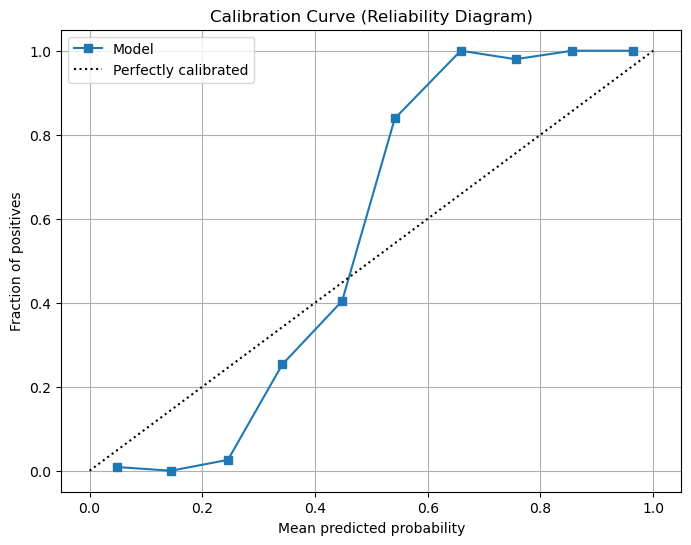

In [40]:
# probs: your predicted probabilities from model.predict_proba(X_test)[:, 1]
# y_test: true labels

# Get fraction of positives and mean predicted value per bin
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, probs, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Model")
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curve (Reliability Diagram)")
plt.legend()
plt.grid(True)
plt.show()

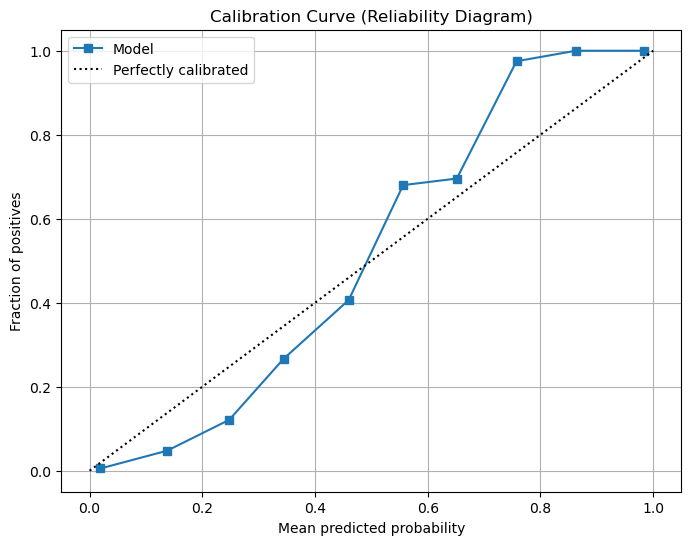

In [42]:
# probs: your predicted probabilities from model.predict_proba(X_test)[:, 1]
# y_test: true labels

# Get fraction of positives and mean predicted value per bin
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, probs_calibrated, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Model")
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curve (Reliability Diagram)")
plt.legend()
plt.grid(True)
plt.show()